In [161]:
import torch
import laplace
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
from main.models import ConvNet, BayesianConvNet
from main.training_models import train_model
from batchbald_redux import repeated_mnist, joint_entropy, batchbald
from laplace.marglik_training import marglik_training
from laplace.curvature import CurvlinopsEF, CurvlinopsGGN, AsdfghjklGGN, AsdfghjklEF

%reload_ext autoreload
%autoreload 2

In [187]:
# load mnist data
train_dataset, val_dataset = repeated_mnist.create_MNIST_dataset()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                           sampler=torch.utils.data.SubsetRandomSampler(range(1000)))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, sampler=torch.utils.data.SubsetRandomSampler(range(1000)))

In [188]:
# train model and jointly optimize for marginal likelihood
model = ConvNet()

la, model, margliks, losses = marglik_training(
    model=model, train_loader=train_loader, likelihood='classification',
    n_epochs=10, hessian_structure='kron', backend=CurvlinopsEF
    )

KeyboardInterrupt: 

In [90]:
# evaluate model on validation set
model.eval()

correct = 0
correct_la = 0
total = 0

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        outputs_la = la(images)

        _, predicted = torch.max(outputs.data, 1)
        _, predicted_la = torch.max(outputs_la.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        correct_la += (predicted_la == labels).sum().item()
        print('Accuracy of the network on the test images: {}'.format(correct_la/total))

print('Accuracy of the network on the 1000 test images: {}'.format(correct/total))
print('Accuracy of the LA on the 1000 test images (LA): {}'.format(correct_la/total))

Accuracy of the network on the test images: 0.875
Accuracy of the network on the test images: 0.890625
Accuracy of the network on the test images: 0.8854166666666666
Accuracy of the network on the test images: 0.8828125
Accuracy of the network on the test images: 0.90625
Accuracy of the network on the test images: 0.9010416666666666
Accuracy of the network on the test images: 0.9017857142857143
Accuracy of the network on the test images: 0.89453125
Accuracy of the network on the test images: 0.8993055555555556


KeyboardInterrupt: 

In [83]:
# collapse data from training_loader into tensor for x and y
x = torch.cat([x for x, y in train_loader], dim=0)
y = torch.cat([y for x, y in train_loader], dim=0)

x_test = torch.cat([x for x, y in val_loader], dim=0)
y_test = torch.cat([y for x, y in val_loader], dim=0)

In [84]:
x_test = x_test[:32]

In [85]:
preds_la = la(x_test)

In [86]:
preds_nn = model(x_test)
# get probabilities from logits
probs_nn = torch.nn.functional.softmax(preds_nn, dim=1)

In [87]:
# User-specified LA flavor
model = ConvNet()

# train model
model = train_model(model, train_loader, num_epochs=10)

la = laplace.Laplace(model,
                     likelihood="classification",
                     subset_of_weights='all',
                     backend=CurvlinopsEF,
                     )

print('Fitting the Laplace approximation...')
la.fit(train_loader, progress_bar=True)

print('Optimizing the prior precision...')
la.optimize_prior_precision(
    method='marglik'
)

# User-specified predictive approx.
#print('Computing the predictive distribution...')
#pred = la(x, pred_type="glm", link_approx="probit")  # probabilities (N x C)

Epoch 1/10, Loss: 0.13061560690402985
Epoch 2/10, Loss: 0.3169635534286499
Epoch 3/10, Loss: 0.3689730763435364
Epoch 4/10, Loss: 0.04879916459321976
Epoch 5/10, Loss: 0.061987604945898056
Epoch 6/10, Loss: 0.03267693147063255
Epoch 7/10, Loss: 0.0023940701503306627
Epoch 8/10, Loss: 0.031161261722445488
Epoch 9/10, Loss: 0.0008983592852018774
Epoch 10/10, Loss: 0.005179723724722862
Fitting the Laplace approximation...


[Computing Hessian]: 100%|██████████| 32/32 [00:01<00:00, 22.66it/s]


Optimizing the prior precision...


## Comparing ways to get the covariance

In [10]:
x_test = x_test[:100]

In [311]:
# mean is (N, C) and variance is (N, C, C)
f_mu, f_var = la._glm_predictive_distribution(x_test)
_, f_var_ood = la._glm_predictive_distribution(torch.rand(1, 1, 28, 28))

# obtain samples of predicted network outputs f. f_samples is (n_samples, N, C)
n_samples = 10000
f_samples = la.predictive_samples(x_test, n_samples=n_samples)

In [281]:
from main.laplace_batch import rank_reduce

#covs = torch.stack([rank_reduce(torch.cov(f_samples[:, n, :].T)) for n in range(f_samples.shape[1])])

v = torch.cov(f_samples[:, 2, :].T)
v_drop = v[1:, 1:]
v_reduced = rank_reduce(v)
np.linalg.matrix_rank(v.numpy())
np.linalg.matrix_rank(v_reduced.numpy())
(torch.det(v_drop)).log() == (torch.det(v_reduced)).log()

tensor(True)

In [12]:
# compute covariance matrix of f_samples for each sample in the batch
# covs is (N, C, C) where covs[n] is the covariance matrix of f_samples[:, n, :]
covs = torch.stack([torch.cov(f_samples[:, n, :].T) for n in range(f_samples.shape[1])])

In [13]:
# compare the two
print('Mean difference: between f_var and covs', torch.mean(torch.abs(f_var - covs)))

Mean difference: between f_var and covs tensor(256.5092)


In [14]:
# turn f_var into block diagonal matrix of size NC x NC
N = x_test.shape[0]
C = 10

f_var_block = torch.zeros(N * C, N * C)
for i in range(N):
    f_var_block[i*C:(i+1)*C, i*C:(i+1)*C] = f_var[i]

# compute eigenvalues of f_var_block
eigvals = np.linalg.eigvals(f_var_block.detach())
nonzeros = np.sum(eigvals > 1e-3)

Number of non-zero eigenvalues: 1000 out of 1000


NB: The number of non-zero eigenvalues is 450 when using the classification likelihood in `predictive_samples` but 500 when using the regression likelihood. This is the effect of using the log_softmax in classification.

## Functional (co)variance using Jacobian

In [332]:
jacobians, _ = la.backend.jacobians(x_test, enable_backprop=True)

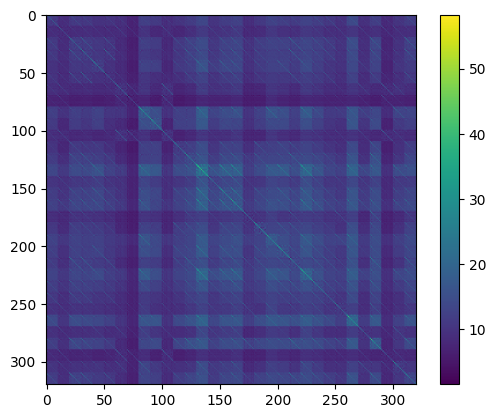

In [331]:
# compute functional covariance
fv = la.functional_covariance(Js=jacobians)

# plot the functional covariance
plt.imshow(fv)
plt.colorbar()
plt.show()

# check it's full rank
assert np.linalg.matrix_rank(fv.numpy()) == fv.shape[0]

## Checking properties covariance categorical

In [113]:
# generate categorical data from {1, 2, ..., C}
# generate M samples
M = 1000
N_ = 100
Y = torch.randint(0, C, (M, N_))

D = torch.cov(Y.T)
# get the eigenvalues of D
eigvals = np.linalg.eigvals(D.detach().numpy())
print(f'Number of eigenvalues below 1e-3: {np.sum(eigvals < 1e-3)} out of {N_}')

Number of eigenvalues below 1e-3: 0 out of 100


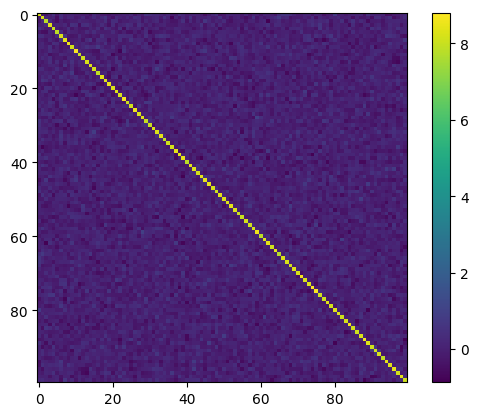

In [116]:
plt.imshow(D.detach().numpy())
plt.colorbar()
plt.show()

## Testing get_laplace_batch

In [217]:
from main.laplace_batch import get_laplace_batch
la = laplace.Laplace(model,
                     likelihood="classification",
                     subset_of_weights='all',
                     hessian_structure='kron',
                     backend=AsdfghjklEF,
                     temperature=1e-1
                     )
la.fit(train_loader, progress_bar=True)

la.optimize_prior_precision(method='marglik', link_approx='probit', pred_type='glm')

[Computing Hessian]: 100%|██████████| 32/32 [00:02<00:00, 10.73it/s]
c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\laplace\baselaplace.py:409: UserWarning: By default `link_approx` is `probit`. Make sure to set it equals to the way you want to call `la(test_data, pred_type=..., link_approx=...)`.
  warnings.warn(


In [218]:
p = la(x_test)  # shape (batch_size, n_classes)
ent = -torch.sum(p * torch.log(p), dim=1).unsqueeze(-1)

In [219]:
f_samples = la.predictive_samples(x_test, n_samples=100000)
p_given_f = torch.nn.functional.softmax(f_samples, dim=2)

In [220]:
# for a given value of f, compute the entropy of the predictive distribution
ent_given_f = -torch.sum(p_given_f * torch.log(p_given_f), dim=2)

# average over samples in dimension 0
expected_ent = torch.mean(ent_given_f, dim=0)

# check shape
ent - expected_ent

tensor([[-0.0517, -0.0508, -0.0490,  ..., -0.0432, -0.0450, -0.0477],
        [-0.1123, -0.1114, -0.1096,  ..., -0.1038, -0.1056, -0.1082],
        [-0.1334, -0.1325, -0.1306,  ..., -0.1249, -0.1267, -0.1293],
        ...,
        [-0.2036, -0.2027, -0.2008,  ..., -0.1951, -0.1969, -0.1995],
        [-0.1335, -0.1326, -0.1307,  ..., -0.1250, -0.1268, -0.1294],
        [-0.1272, -0.1263, -0.1245,  ..., -0.1188, -0.1206, -0.1232]])

something wrong here since this is supposed to correspond to MI which is nonnegative

### Trying again using batchbald.joint_entropy functions

In [226]:
log_probs_N_K_C = torch.log(p_given_f).swapaxes(0, 1)

conditional_ent = batchbald.compute_conditional_entropy(log_probs_N_K_C)
ent = batchbald.compute_entropy(log_probs_N_K_C)

# score
score = ent - conditional_ent
score


tensor([0.0286, 0.0269, 0.0276, 0.0300, 0.0336, 0.0278, 0.0314, 0.0233, 0.0320,
        0.0351, 0.0270, 0.0331, 0.0329, 0.0391, 0.0296, 0.0344, 0.0339, 0.0316,
        0.0358, 0.0334, 0.0383, 0.0305, 0.0362, 0.0312, 0.0277, 0.0321, 0.0340,
        0.0299, 0.0342, 0.0260, 0.0337, 0.0293], dtype=torch.float64)